# MNE epoching

In this notebook, we explore the possibilities of MNE to convert our raw EEG data into interesting fragments, called epochs in MNE. MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more. It does not have a direct link to the paper but the expertise gained here is used in the paper.

This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in `bci-master-thesis/experimental-notebooks/1-CLA-dataset-exploration-notebook.ipynb` and `bci-master-thesis/experimental-notebooks/2-MNE-datastructure-exploration-notebook.ipynb`. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

We rely on the [MNE provided tutorials](https://mne.tools/stable/auto_tutorials/index.html) for this notebook.

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
  - Validating correct annotations and events
- Creating MNE epochs
- Plotting MNE epochs
  - General plots
  - Averaged plots

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [10]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [11]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`.

In [12]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. 
However, thanks to the written `CLA_dataset` util file we can easily get the MNE raw data from it, FIF files of which are also provided on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

Please specify the filename in the below code block. For more info on which variants are available, please look at the `bci-master-thesis/code/data/CLA/README.md` file.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [13]:
####################################################
# LOADING RAW MNE DATA
####################################################

# You can specify the data file to use here, per default it is CLASubjectB1512153StLRHand
data_file_name = "CLASubjectB1512153StLRHand"

mne_raw = CLA_dataset.get_raw_mne_data(data_file_name)

print(f"Loaded MNE for {data_file_name}:\n")
display(mne_raw)

Loaded MNE for CLASubjectB1512153StLRHand:



<Raw | CLASubjectB1512153StLRHand_raw.fif, 21 x 667800 (3339.0 s), ~37 kB, data not loaded>

### Validating correct annotations and events

In the previous notebook, `2-MNE-datastructure-exploration-notebook.ipynb`, annotations and events were added to the MNE raw object.
We validate that these changes were loaded correctly in what follows.

In [14]:
####################################################
# VALIDATE ANNOTATIONS AND EVENTS
####################################################

# Validate length
print(f"EEG time in seconds according to MNE: {mne_raw.times.max()} seconds")
print(f"Duration of EEG data manually calculated: {mne_raw.__len__() / mne_raw.info['sfreq']} seconds")

# Validate annotations
important_markers = CLA_dataset.get_important_markers(data_file_name)

print(f"\n\nFirst annotation starts at {mne_raw.annotations[0]['onset']} seconds and ends at {mne_raw.annotations[0]['onset'] + mne_raw.annotations[0]['duration']} seconds with textual marker: {mne_raw.annotations[0]['description']}")
print(f"First important marker starts at {important_markers[0].start_idx / mne_raw.info['sfreq']} seconds and ends at {important_markers[0].end_idx / mne_raw.info['sfreq']} seconds with textual marker: {CLA_dataset.marker_to_textual_dict[important_markers[0].mark]}")


print(f"\nSecond annotation starts at {mne_raw.annotations[1]['onset']} seconds and ends at {mne_raw.annotations[1]['onset'] + mne_raw.annotations[1]['duration']} seconds with textual marker: {mne_raw.annotations[1]['description']}")
print(f"Second important marker starts at {important_markers[1].start_idx / mne_raw.info['sfreq']} seconds and ends at {important_markers[1].end_idx / mne_raw.info['sfreq']} seconds with textual marker: {CLA_dataset.marker_to_textual_dict[important_markers[1].mark]}")


print(f"\nAnnotation 500 starts at {mne_raw.annotations[500]['onset']} seconds and ends at {mne_raw.annotations[500]['onset'] + mne_raw.annotations[500]['duration']} seconds with textual marker: {mne_raw.annotations[500]['description']}")
print(f"Important marker 500 starts at {important_markers[500].start_idx / mne_raw.info['sfreq']} seconds and ends at {important_markers[500].end_idx / mne_raw.info['sfreq']} seconds with textual marker: {CLA_dataset.marker_to_textual_dict[important_markers[500].mark]}")


print(f"\nAnnotation 1000 starts at {mne_raw.annotations[1000]['onset']} seconds and ends at {mne_raw.annotations[1000]['onset'] + mne_raw.annotations[1000]['duration']} seconds with textual marker: {mne_raw.annotations[1000]['description']}")
print(f"Important marker 1000 starts at {important_markers[1000].start_idx / mne_raw.info['sfreq']} seconds and ends at {important_markers[1000].end_idx / mne_raw.info['sfreq']} seconds with textual marker: {CLA_dataset.marker_to_textual_dict[important_markers[1000].mark]}")

# Validate events
mne_events, mne_event_conversion_dict = CLA_dataset.get_events_and_dict_from_annotated_raw(mne_raw)

print(f"\n\nFirst event starts at sample {mne_events[0][0]} with marker {mne_events[0][2]}")
print(f"First important marker starts at sample {important_markers[0].start_idx} with marker {important_markers[0].mark}")

print(f"\nSecond event starts at sample {mne_events[1][0]} with marker {mne_events[1][2]}")
print(f"Second important marker starts at sample {important_markers[1].start_idx} with marker {important_markers[1].mark}")

print(f"\nEvent 500 starts at sample {mne_events[500][0]} with marker {mne_events[500][2]}")
print(f"Important marker 500 starts at sample {important_markers[500].start_idx} with marker {important_markers[500].mark}")

print(f"\nEvent 1000 starts at sample {mne_events[1000][0]} with marker {mne_events[1000][2]}")
print(f"Important marker 1000 starts at sample {important_markers[1000].start_idx} with marker {important_markers[1000].mark}")


# Remove unused variables
del important_markers
del mne_event_conversion_dict


EEG time in seconds according to MNE: 3338.995 seconds
Duration of EEG data manually calculated: 3339.0 seconds


First annotation starts at 0.0 seconds and ends at 180.52499389648438 seconds with textual marker: info/blank_screen
First important marker starts at 0.0 seconds and ends at 180.525 seconds with textual marker: info/blank_screen

Second annotation starts at 180.529999 seconds and ends at 181.53999350683594 seconds with textual marker: task/left
Second important marker starts at 180.53 seconds and ends at 181.54 seconds with textual marker: task/left

Annotation 500 starts at 933.565002 seconds and ends at 935.6049800273438 seconds with textual marker: info/blank_screen
Important marker 500 starts at 933.565 seconds and ends at 935.605 seconds with textual marker: info/blank_screen

Annotation 1000 starts at 1800.52002 seconds and ends at 1802.37500046875 seconds with textual marker: info/blank_screen
Important marker 1000 starts at 1800.52 seconds and ends at 1802.375 secon

Opening raw-browser...


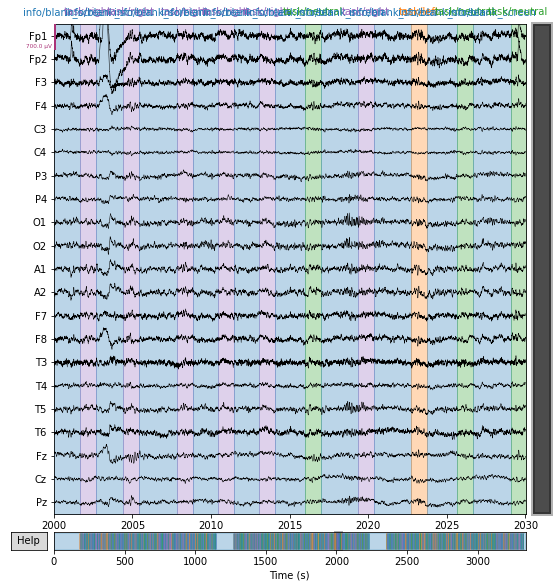

In [15]:
####################################################
# VALIDATE MNE PLOT
####################################################

# Plot inline or in popup
%matplotlib inline
# %matplotlib qt 

# Default plot function scaled to usable visualisation of 30 seconds of data 
mne_raw.plot(duration=30,
                  start=2000,
                  scalings=dict(eeg=0.00035),
                  n_channels=22)

plt.show()


<hr><hr>

## Creating MNE epochs

We create the MNE epochs objects from the MNE RAW file and Event objects that were already obtained and other metrics.
We specify:

- raw: RAW object of MNE to epoch
- events: events to use for epoching
- event_id: make it so we can work with textual labels instead of markers (int)
  - This dict may only contain values that are actually present
  - Only values present will be included, this can be used to not include markers that are not of use
- tmin: *start time* in seconds for epoch, e.g. time w.r.t. event before/after event that should be included
  - -0.2 to include 0.2 seconds before shown queue
- tmax: *end time* in seconds for epoch, e.g. time w.r.t. event before/after event that should be included
  - 1.2 since queue is shown 1 second and we include some extra time like we did for the start time
- picks: Channels to include
  - No filtering as of now but usefull potion
- preload: is set to true since this is faster and we have enough memory to load all data
- reject: Reject epochs based on maximum peak-to-peak signal amplitude (PTP), i.e. the absolute difference between the lowest and the highest signal value. In each individual epoch, the PTP is calculated for every channel. If the PTP of any one channel exceeds the rejection threshold, the respective epoch will be dropped.
  - Good to exclude samples were very abrupt changes happen, hinting artefacts rather then usefull EEG
  - Not used as of now to include all data and be "realistic"
- flat: Reject epochs based on minimum peak-to-peak signal amplitude (PTP). Valid keys can be any channel type present in the object. The values are floats that set the minimum acceptable PTP. If the PTP is smaller than this threshold, the epoch will be dropped.
  - Not usefull when including all channels but could be usefull when only including MI channels where variation is expected
  - Not used as of now to include all data and be "realistic"

In [16]:
####################################################
# CREATING MNE EPOCHS
####################################################

# Only consider the MI tasks               
usefull_event_id = {"task/left": 1,
                    "task/right": 2,
                    "task/neutral": 3}

# Get the epochs
mne_epochs = mne.Epochs(raw= mne_raw, events= mne_events,
                        event_id= usefull_event_id,
                        tmin= -0.2
                        
                        
                        
                        
                        
                        
                        
                        , tmax= 1.2,
                        preload= True)

# Show the epoch findings
print("\n")
display(mne_epochs)

# Remove unused vars
del usefull_event_id

Not setting metadata
960 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 960 events and 281 original time points ...
0 bad epochs dropped




Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-0.200 – 1.200 sec
Baseline,-0.200 – 0.000 sec


We can see that the distribution of MI tasks is pretty uniform.
For completeness sake, we drop epochs to make the amount of epochs per MI task equal as to reduce the bias.

In [17]:
####################################################
# EQUALING EPOCH SAMPLES
####################################################

# Keep all types and equalize by dropping epochs
mne_epochs.equalize_event_counts()

# Show the epoch findings
display(mne_epochs)

Dropped 18 epochs: 804, 812, 814, 818, 819, 827, 846, 847, 849, 854, 856, 869, 872, 873, 874, 879, 958, 959


Number of events,942
Events,task/left: 314task/neutral: 314task/right: 314
Time range,-0.200 – 1.200 sec
Baseline,-0.200 – 0.000 sec


We now see that the amount of epoch samples for each task are indeed equal.

## Plotting MNE epochs

### General plots

We show the general plots and limit ourself to the electrodes that represent the motor cortex.

In [18]:
####################################################
# SHOWING EPOCH FIGURES
####################################################

# Get plot figures
neutral_figs = mne_epochs['task/neutral'].plot_image(picks= CLA_dataset.motor_cortex_electrodes,
                                                     show=False)

left_figs = mne_epochs['task/left'].plot_image(picks= CLA_dataset.motor_cortex_electrodes,
                                               show=False)

right_figs = mne_epochs['task/right'].plot_image(picks= CLA_dataset.motor_cortex_electrodes,
                                                 show=False)

# Don't show figures but save them instead
for fig in neutral_figs:
    title = fig.axes[0].get_title()
    fig.axes[0].set_title("task/neutral " + title)
    fig.savefig(f"figures/3-mne-epoching/neutral_{title}", facecolor="white")
    plt.close(fig)
    
for fig in left_figs:
    title = fig.axes[0].get_title()
    fig.axes[0].set_title("task/left " + title)
    fig.savefig(f"figures/3-mne-epoching/left_{title}", facecolor="white")
    plt.close(fig)
    
for fig in right_figs:
    title = fig.axes[0].get_title()
    fig.axes[0].set_title("task/right " + title)
    fig.savefig(f"figures/3-mne-epoching/right_{title}", facecolor="white")
    plt.close(fig)
    
# Remove unused vars
del fig
del neutral_figs
del right_figs
del left_figs
del title

Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activat

### T3

<p align="center">
  <img src="figures/3-mne-epoching/neutral_T3.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/left_T3.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/right_T3.png" width="30%">
</p>

### C3

<p align="center">
  <img src="figures/3-mne-epoching/neutral_C3.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/left_C3.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/right_C3.png" width="30%">
</p>

### Cz

<p align="center">
  <img src="figures/3-mne-epoching/neutral_Cz.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/left_Cz.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/right_Cz.png" width="30%">
</p>

### C4

<p align="center">
  <img src="figures/3-mne-epoching/neutral_C4.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/left_C4.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/right_C4.png" width="30%">
</p>

### T4

<p align="center">
  <img src="figures/3-mne-epoching/neutral_T4.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/left_T4.png" width="30%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img src="figures/3-mne-epoching/right_T4.png" width="30%">
</p>

### Averaged plots


We now show averaged plots to get an idea of the evoked response.
We do this for each sensor to see which sensors have biggest difference and thus might have most usefull information.

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


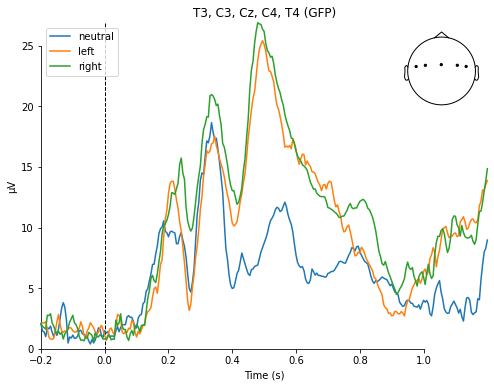

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


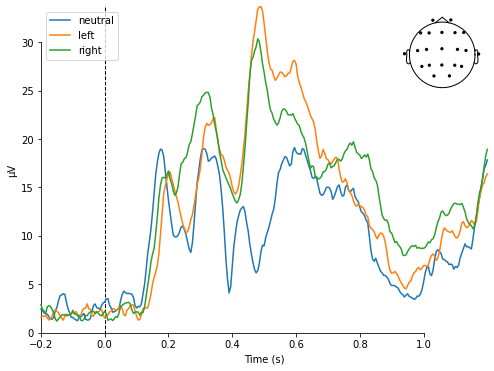

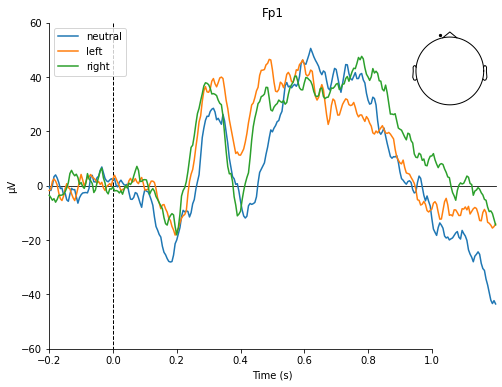

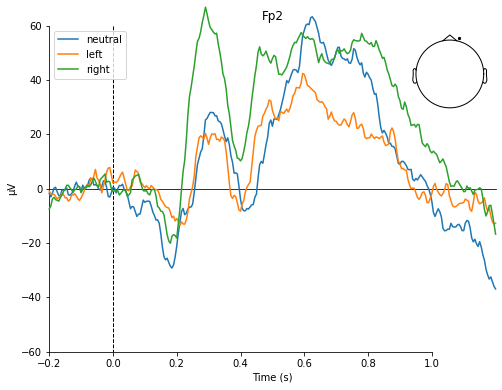

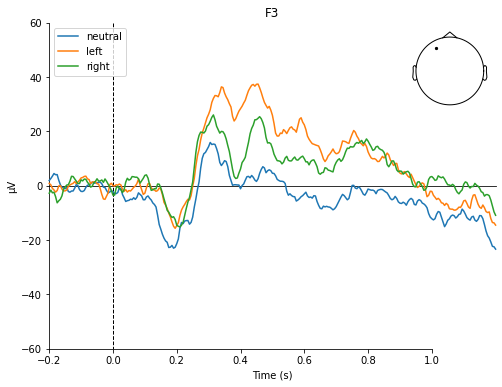

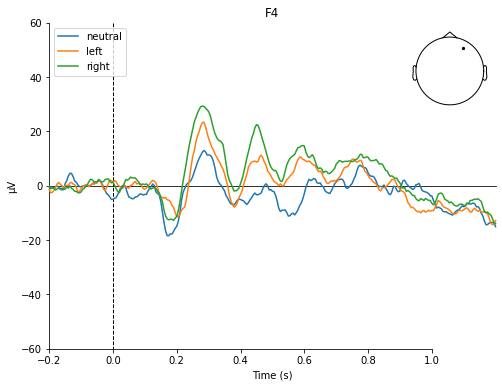

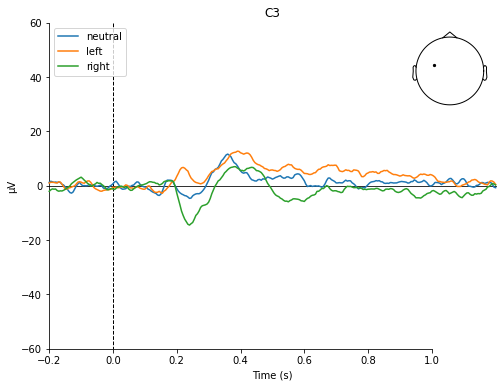

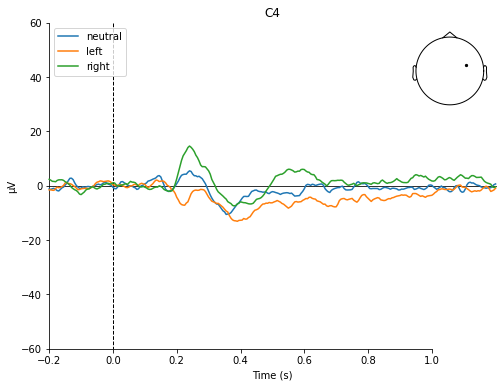

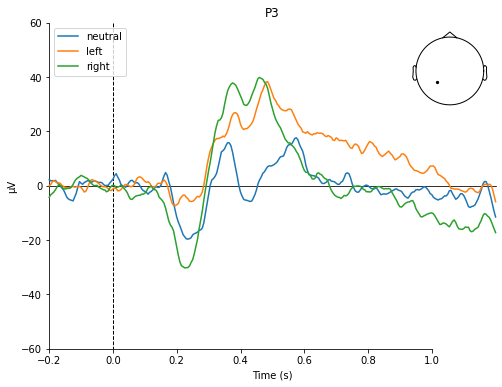

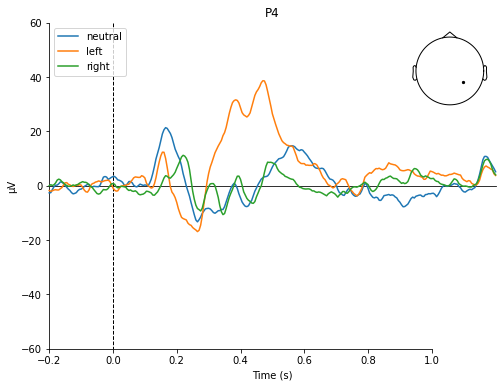

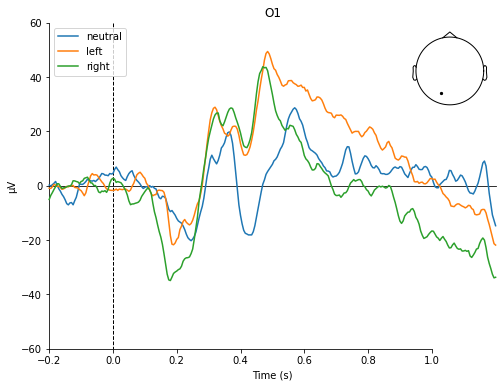

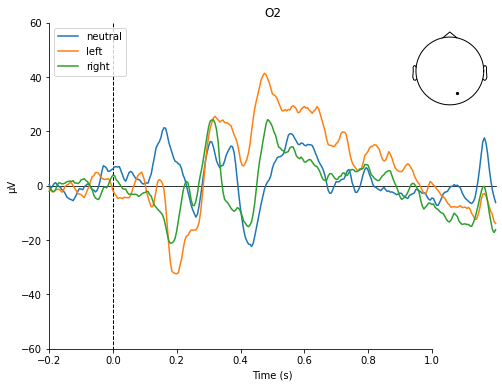

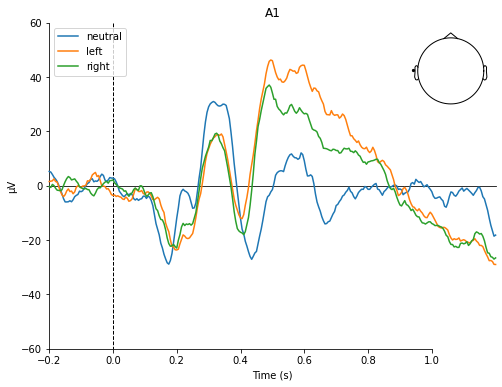

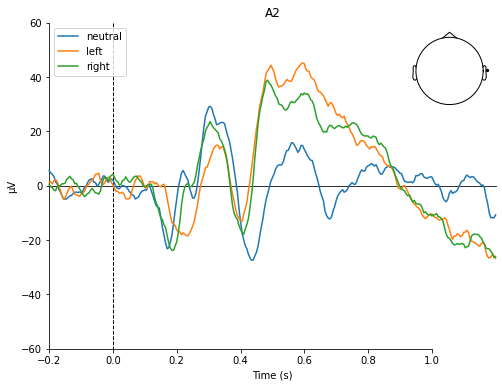

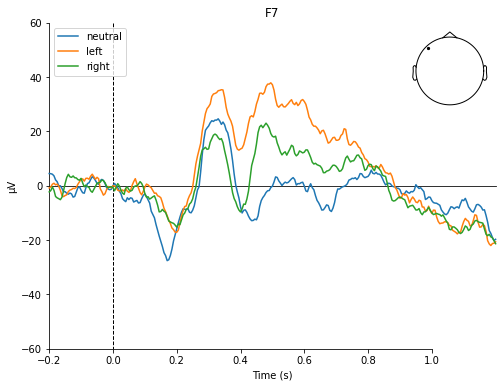

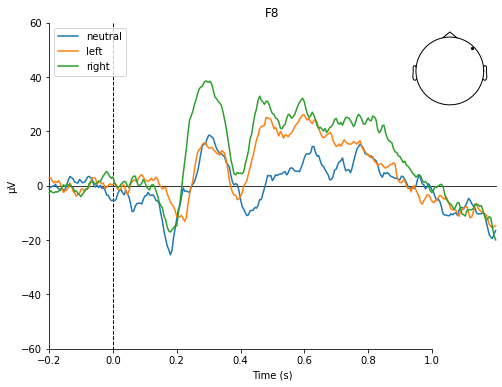

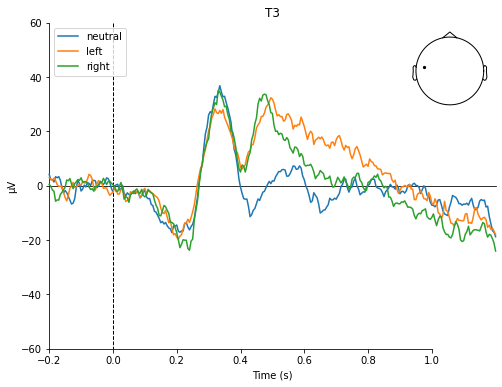

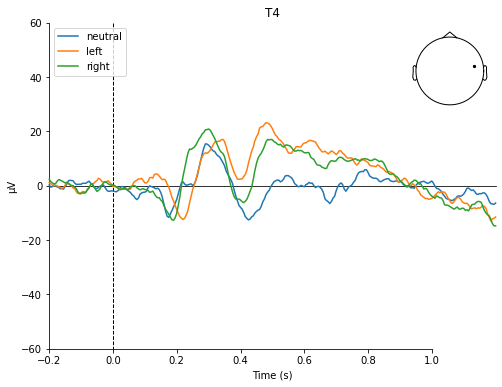

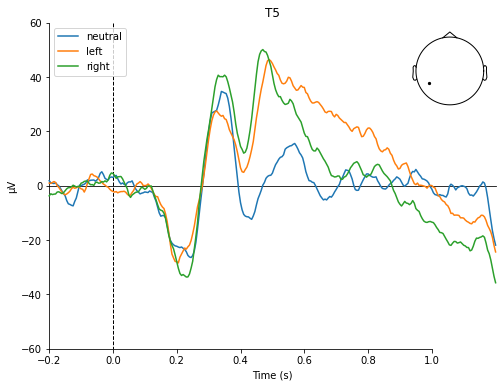

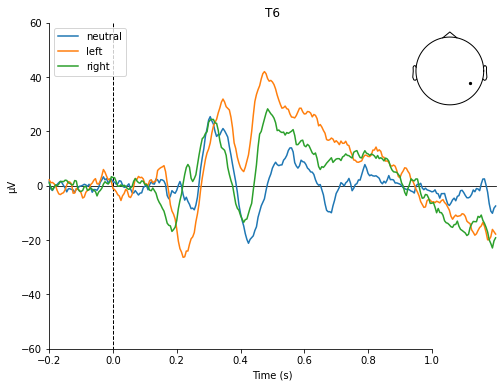

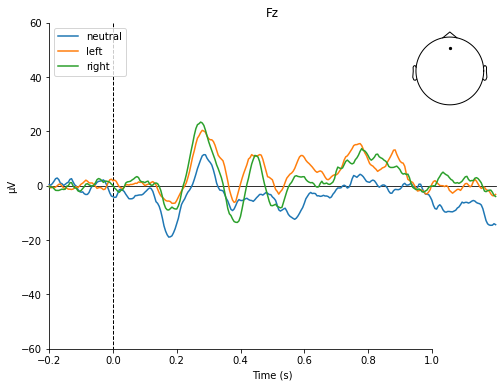

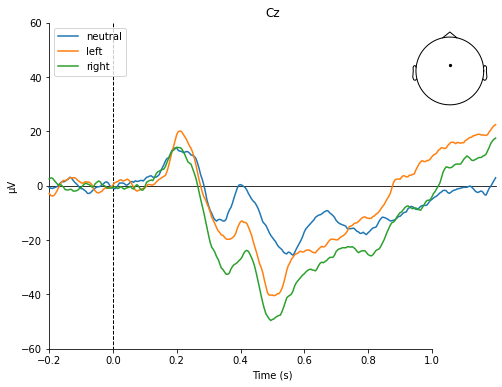

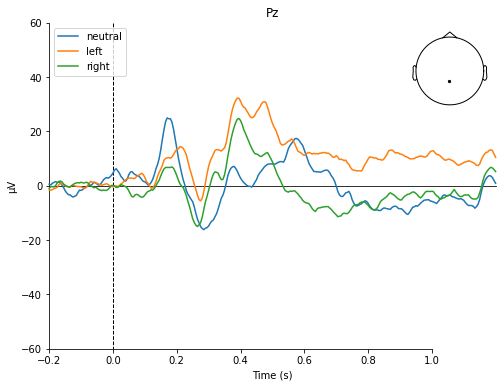

In [19]:
####################################################
# SHOWING AVERAGED EPOCHS
####################################################

neutral_evoked =  mne_epochs['task/neutral'].average()
left_evoked =  mne_epochs['task/left'].average()
right_evoked =  mne_epochs['task/right'].average()

mne.viz.plot_compare_evokeds(dict(neutral= neutral_evoked, left= left_evoked, right= right_evoked),
                             picks= CLA_dataset.motor_cortex_electrodes,
                             legend='upper left', show_sensors='upper right')

mne.viz.plot_compare_evokeds(dict(neutral= neutral_evoked, left= left_evoked, right= right_evoked),
                             legend='upper left', show_sensors='upper right')

for electrode in mne_raw.ch_names:
    mne.viz.plot_compare_evokeds(dict(neutral= neutral_evoked, left= left_evoked, right= right_evoked),
                                 picks= electrode,
                                 ylim=dict(eeg=[-60, 60]),
                                 legend='upper left', show_sensors='upper right')
# Delete unused var
del electrode
del neutral_evoked
del right_evoked
del left_evoked

### Topomaps

To further study the activity per electrode we study the topomaps.

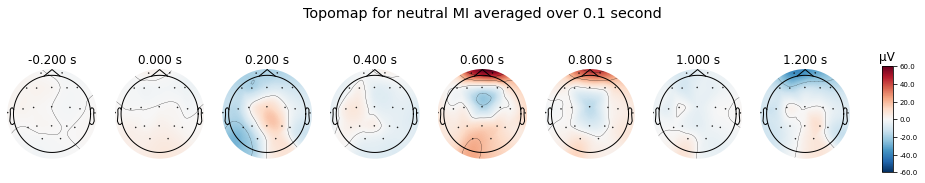

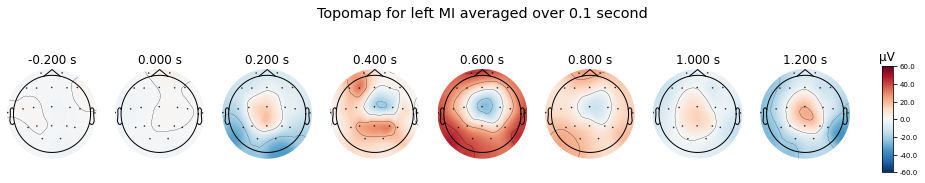

In [20]:
####################################################
# SHOWING TOPOMAPS
####################################################

# Get averaged aka EvokedArray
neutral_evoked =  mne_epochs['task/neutral'].average()
left_evoked =  mne_epochs['task/left'].average()
right_evoked =  mne_epochs['task/right'].average()

neutral_evoked.plot_topomap(times=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
                            ch_type='eeg',
                            average=0.1,
                            vmin=-60, vmax=60,
                            title="Topomap for neutral MI averaged over 0.1 second")

left_evoked.plot_topomap(times=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
                            ch_type='eeg',
                            average=0.1,
                            vmin=-60, vmax=60,
                            title="Topomap for left MI averaged over 0.1 second")

right_evoked.plot_topomap(times=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
                            ch_type='eeg',
                            average=0.1,
                            vmin=-60, vmax=60,
                            title="Topomap for right MI averaged over 0.1 second")

# Delete unused var
del neutral_evoked
del right_evoked
del left_evoked

### Joined plots

Ideally, both the averaged EEG data and topomaps should be combined. Luckily MNE provides functionalities for this as well. 

No projector specified for this dataset. Please consider the method self.add_proj.


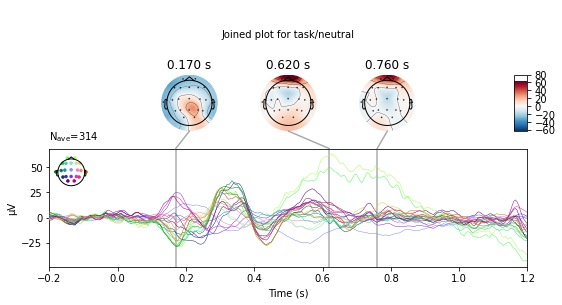

No projector specified for this dataset. Please consider the method self.add_proj.


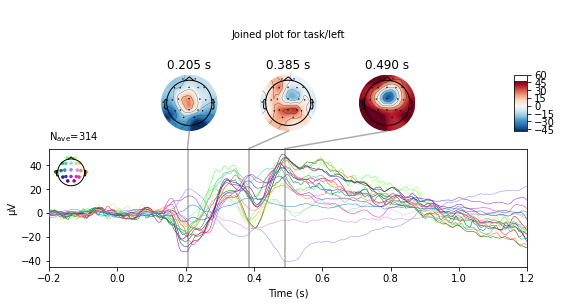

No projector specified for this dataset. Please consider the method self.add_proj.


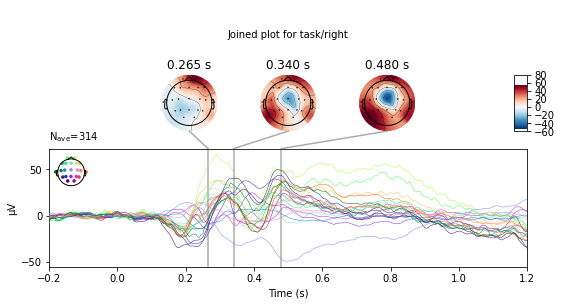

In [ ]:
####################################################
# SHOWING JOINT PLOTS
####################################################

# Get averaged aka EvokedArray
neutral_evoked =  mne_epochs['task/neutral'].average()
left_evoked =  mne_epochs['task/left'].average()
right_evoked =  mne_epochs['task/right'].average()

neutral_evoked.plot_joint(picks= 'eeg',
                          title="Joined plot for task/neutral")

left_evoked.plot_joint(picks= 'eeg',
                       title="Joined plot for task/left")

right_evoked.plot_joint(picks= 'eeg',
                        title="Joined plot for task/right")

# Delete unused var
del neutral_evoked
del right_evoked
del left_evoked